Notes to self
This is tempermental to module version
Use base conda env on MacBook Pro laptop

In [122]:
# --------------------------------------------------- #
# Specific version for current Scarlet2               #
# run this is having issue with commands not existing #
# make a standalone conda env for now, fix later      #
# --------------------------------------------------- #
## uninstall current versions of jax, jaxlib, diffrax, equinox

# un-comment below here and run cell
# import time
# !pip uninstall jax -y
# !pip uninstall diffrax -y
# !pip uninstall equinox -y
# !pip uninstall jaxlib -y

# # now install correct versions
# !pip install diffrax==0.2.0
# time.sleep(5)
# !pip install equinox==0.8.0
# time.sleep(5)
# !pip install jaxlib==0.3.20
# time.sleep(5)
# !pip install jax==0.3.22
# !pip install galaxygrad # - library with trained nn weights

In [123]:
# specify to reload any packages that are changed
# helps with not having to restart the kernel each time
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [124]:
import numpy as np
import jax.numpy as jnp
import equinox as eqx
from jax import random, jit
import distrax
import matplotlib.pyplot as plt
from scarlet2 import *
import optax
from tqdm.auto import tqdm
import pandas as pd
import warnings
warnings.filterwarnings("ignore") # suppress version depreciation warnings of jax.tree_structure 
plt.style.use('dark_background')

In [125]:
# ----------------------------------- #
# grab images from the HSC catalogue  #
# read them into jax arrays and then  #
# make a multi-band image             #
# ----------------------------------- #
# use 14090 great examle
# 15290 ok

data_name = 'data_HSC_9697_patch_72.pkl' # storing just one patch locally so use it
df = pd.read_pickle(data_name) # 13827 is cool
data = df[df['parent_ID']==df['parent_ID'][14090]] # select one randome scene 15100 is cool

# make multi-band data
multi_images = np.array([np.array(data['scene_g'])[0] , np.array(data['scene_r'])[0]  , np.array(data['scene_i'])[0]  , 
                        np.array(data['scene_y'])[0]  , np.array(data['scene_z'])[0] ]) 
multi_filters = np.array([np.array(data['mask_g'])[0] , np.array(data['mask_r'])[0]  , np.array(data['mask_i'])[0]  , 
                        np.array(data['mask_y'])[0]  , np.array(data['mask_z'])[0] ]) 
multi_var = np.array([np.array(data['var_g'])[0] , np.array(data['var_r'])[0]  , np.array(data['var_i'])[0]  , 
                        np.array(data['var_y'])[0]  , np.array(data['var_z'])[0] ]) 
multi_psf = np.array([np.array(data['PSF_g'])[0] , np.array(data['PSF_r'])[0]  , np.array(data['PSF_i'])[0]  , 
                        np.array(data['PSF_y'])[0]  , np.array(data['PSF_z'])[0] ]) 

images = multi_images 
centers = jnp.asarray( [(src[0], src[1]) for src in data["loc"]] )
box_size = jnp.asarray( [(src) for src in data["box_sz"]] )
weights = 1/multi_var 
psf = multi_psf
obs = Observation(images, weights, psf=ArrayPSF(jnp.asarray(psf)))
frame_psf = GaussianPSF(jnp.array((0, 0.2)), 0.7)
model_frame = Frame(Box(images.shape), psf=frame_psf)
obs.match(model_frame);

print('----------------------------------------')
print(f"    Scene contains {len(data['loc'])} galaxy sources")
print('----------------------------------------')

----------------------------------------
    Scene contains 6 galaxy sources
----------------------------------------


In [126]:
# file = np.load("hsc_cosmos_35.npz")
# data = file["images"]
# weights = 1/file["variance"]
# psf = file["psfs"]
# centers = jnp.asarray( [(src['y'], src['x']) for src in file["catalog"]] )
# obs = Observation(data, weights, psf=ArrayPSF(jnp.asarray(psf)))
# frame_psf = GaussianPSF(jnp.array((0, 0.2)), 0.7)
# model_frame = Frame(Box(data.shape), psf=frame_psf)
# obs.match(model_frame);
# print('----------------------------------------')
# print(f"    Scene contains {len(data)} galaxy sources")
# print('----------------------------------------')

In [127]:
# define initial circular model for initial morphology estimate 
from skimage import draw

# empty list
morph_init = [None]*len(centers)
key = random.split(random.PRNGKey(0), 1)
sigma = 1.0 # noise factor

for i, bx in enumerate(box_size):
    arr = np.zeros((bx, bx))
    rr, cc = draw.disk((bx/2, bx/2), radius=bx/7, shape=arr.shape)
    arr[rr, cc] = 1
    noise = random.normal(key, (box_size[i], box_size[i]))
    raw = noise # (jnp.array(arr) + sigma * noise)
    normed = (raw-jnp.min(raw))/(jnp.max(raw)-jnp.min(raw))
    morph_init[i] = normed

In [128]:
# try to mess around getting prior to work
# TODO: determine best way to ensure prior is being used

keys = random.split(random.PRNGKey(0), 2)
with Scene(model_frame) as scene:
    for i in range(len( centers )):
        Source(
            centers[i],
            ArraySpectrum(random.normal(keys[0], (5,)), constraint=PositiveConstraint()),
            ArrayMorphology(morph_init[i], prior=NNPrior())
        )

In [129]:
# TODO: fix "jax.tree_structure" is deprecated so we can use latest jax and equinox
# TODO: fix the non-hashable item in Observation class so we can use jit
src_num = len( centers )
max_weight = 200
weight = 0

@eqx.filter_value_and_grad
def loss_fn_with_grad(model, obs, weight):
    test = 0.0
    sources = model()
    neg_log_like = -obs.log_likelihood(sources)
    for i in range(src_num):
        test += weight * model.sources[i].morphology.prior.log_prob( model.sources[i].morphology.value )
    return  neg_log_like - test #model.log_prior()  

#@eqx.filter_jit
# TODO: Hash error when using jit in the Observation class -- think I need to convert tuple to list?
def make_step(model, obs, opt_state, weigth):
    loss, grads = loss_fn_with_grad(model, obs, weigth)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, grads, model, opt_state


learning_rate= 0.15 #3e-1 # alter this
optim = optax.adam(learning_rate)
opt_state = optim.init(eqx.filter(scene, eqx.is_array))
best_loss = 1e20
iters = 300
loss_vec = []
factor_vec = []

pbar = tqdm(range(iters), desc='fitting sources')
for step in pbar:
    loss, grads, scene, opt_state = make_step(scene, obs, opt_state, weight)
    loss = loss.item()
    factor =  1 - jnp.abs(best_loss - loss) / jnp.max(jnp.array([loss, best_loss]))
    if loss < best_loss: best_loss = loss
    weight = factor * max_weight
    loss_vec.append(loss)
    factor_vec.append(factor)
    pbar.set_description(f" fitting sources ==>  step: {step} loss: {loss}")
        
print(f"final step={step} loss={loss}")

fitting sources:   0%|          | 0/300 [00:00<?, ?it/s]

final step=299 loss=98462.4375


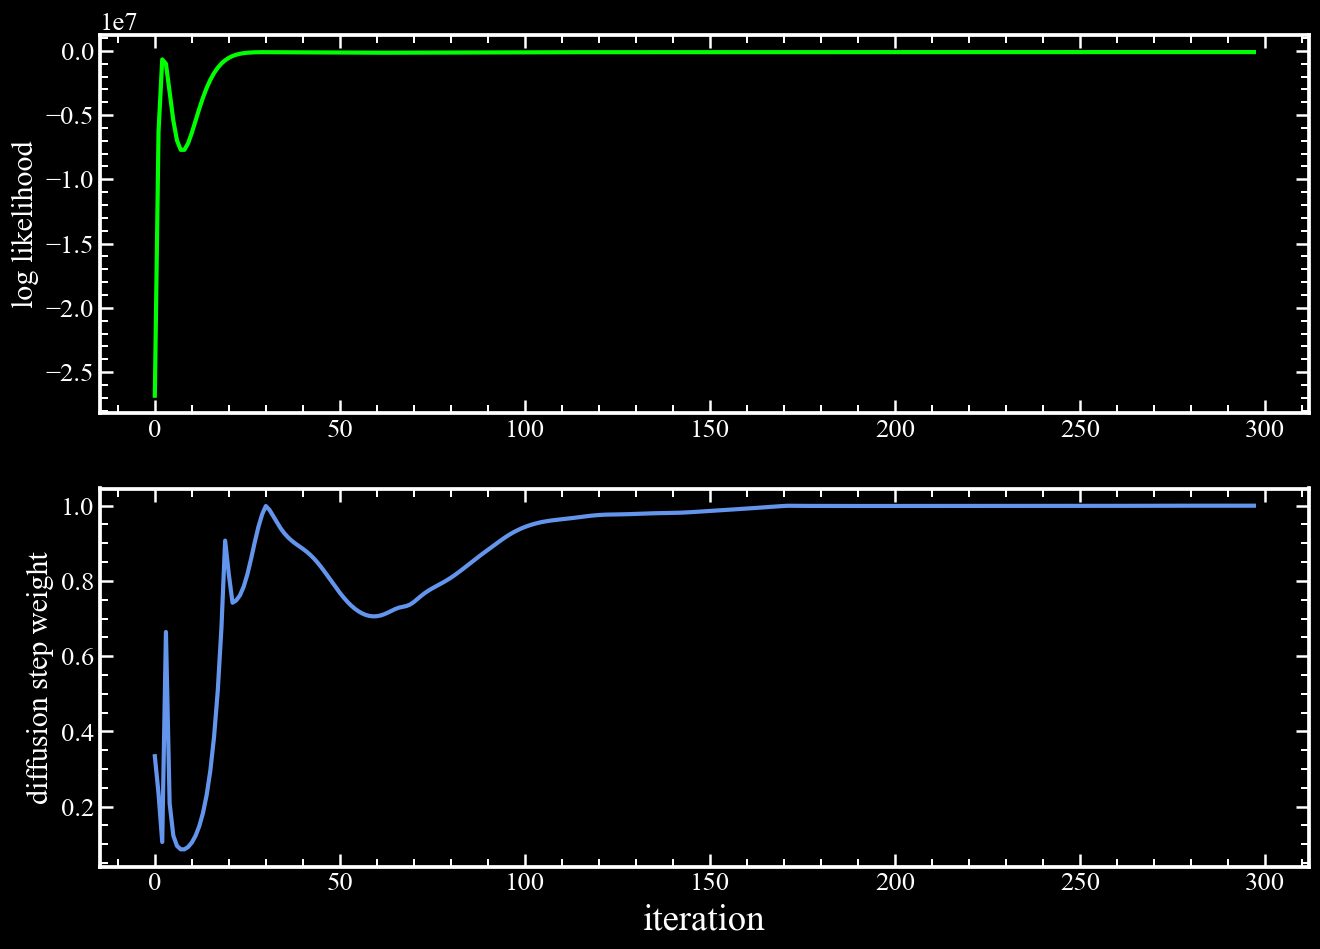

In [130]:
fig = plt.figure(figsize=(13, 9), dpi = 120)
plt.subplot(2,1,1)
plt.plot(-1 * np.array(loss_vec[1:-1]), color='lime')
plt.ylabel("log likelihood", fontsize=18)
plt.subplot(2,1,2)
plt.plot(factor_vec[1:-1], color = 'cornflowerblue')
plt.xlabel('iteration', fontsize=22)
plt.ylabel('diffusion step weight', fontsize=18)
plt.show()

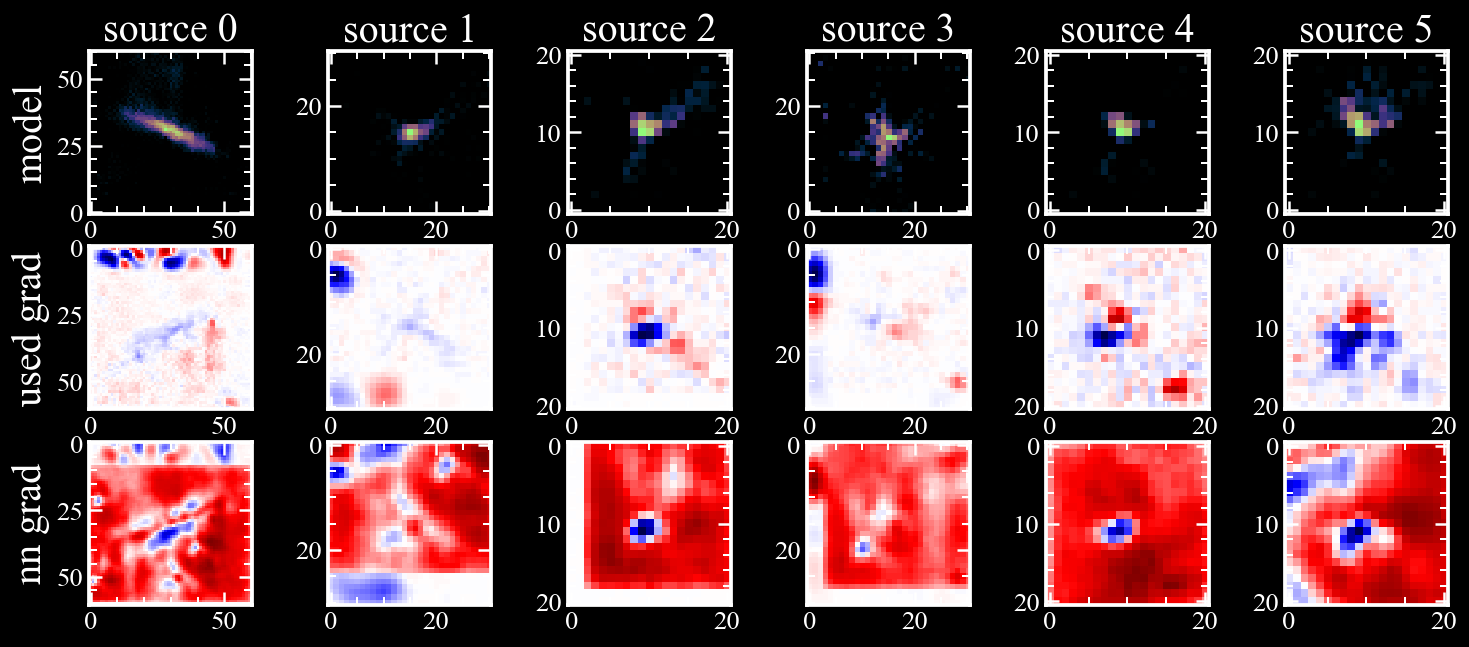

In [131]:
# test to see if issue is with image storage type
# NOTE: nope works fine. grads correctly calculated, but not with the log_prior routine
import jax
import cmasher as cmr
int_method = 'none'

fig = plt.figure(figsize=(15, 6), dpi = 120)
num_src = len( scene.sources )
for idx in range(num_src):
    y = scene.sources[idx].morphology.value
    nn = NNPrior()
    grads_src = jax.grad(nn.log_prob)(y)
    grad_used = grads.sources[idx].morphology.value

    # source morphology
    plt.subplot(3, num_src, idx + 1)
    plt.imshow(y,cmap = cmr.lilac, vmin = 0,interpolation=int_method)
    plt.gca().invert_yaxis()
    plt.title(f"source {idx}", fontsize = 24)
    if idx==0:
        plt.ylabel("model", fontsize = 24)
        
    # used grads
    plt.subplot(3,num_src, idx + num_src + 1)
    plt.gca().invert_yaxis()
    tmax = np.max(np.abs(grad_used))
    plt.imshow(grad_used,cmap = 'seismic', vmin = -tmax, vmax = tmax, interpolation=int_method)
    if idx==0:
        plt.ylabel("used grad", fontsize = 24)
        
    # nn grads
    plt.subplot(3, num_src, idx + 2 * num_src + 1)
    plt.gca().invert_yaxis()
    tmax = np.max(np.abs(grads_src))
    plt.imshow(grads_src,cmap = 'seismic_r', vmin = -tmax, vmax = tmax, interpolation=int_method)
    if idx==0:
        plt.ylabel("nn grad", fontsize = 24)

In [132]:
import cmasher as cmr
# TODO: Make proper normalising and stretching routine like the Lupton one
from astropy.visualization.stretch import SinhStretch, LinearStretch
from astropy.visualization import ImageNormalize
stretch = LinearStretch(slope=0.5, intercept=0.5) + SinhStretch() + \
    LinearStretch(slope=1, intercept=-1)
norm = ImageNormalize(stretch=stretch, vmin=0, vmax=1.7)
int_method='none'
cmap = cmr.lilac

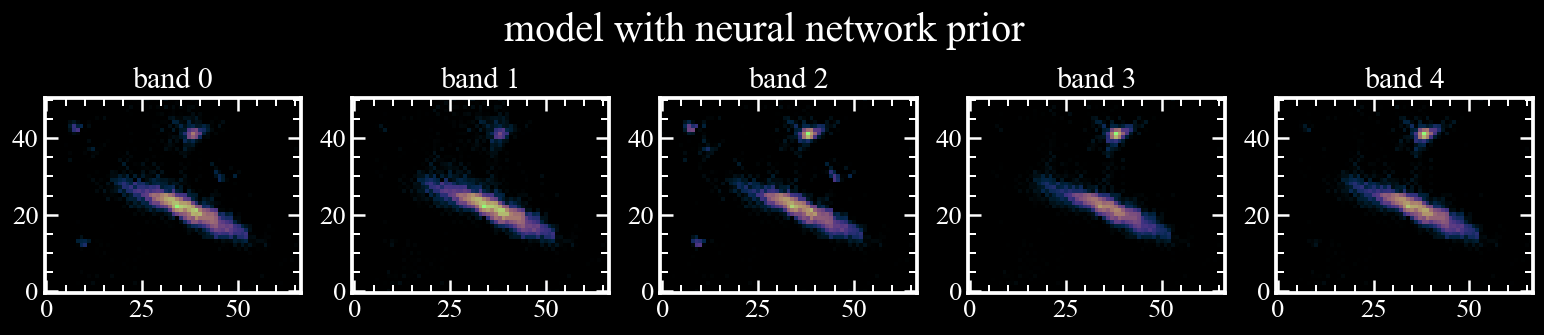

In [133]:
# create some plots to see how the sources look
sources = scene()
fig, axes = plt.subplots(1, sources.shape[0], figsize=(16,6),dpi=120)
for i, ax in enumerate(axes):
    y = sources[i]
    ax.imshow(y, cmap = cmap, vmin = 0, interpolation=int_method)
    ax.set_title(f"band {i}", fontsize = 18)
    ax.invert_yaxis()
plt.suptitle('model with neural network prior', fontsize=24,y=0.75)
#plt.suptitle('model no prior', fontsize=24,y=0.72)
plt.show()

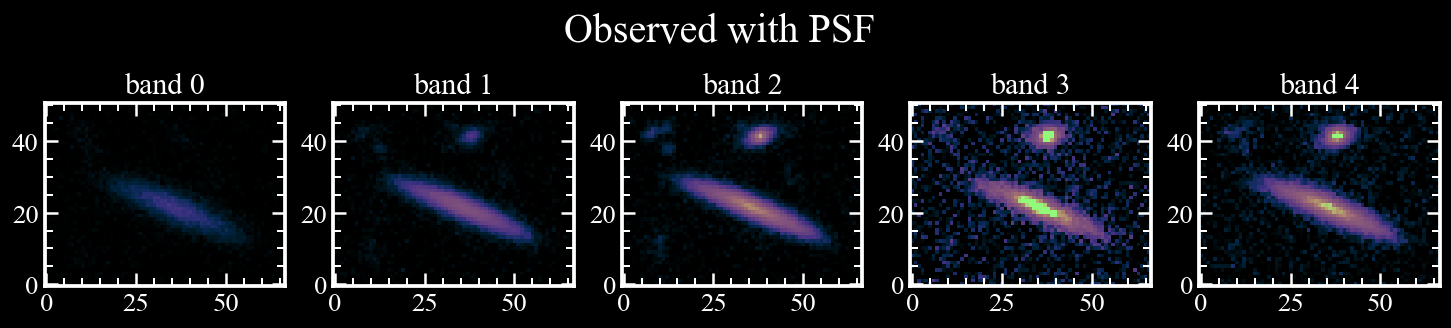

In [134]:
fig, axes = plt.subplots(1, sources.shape[0], figsize=(15,6),dpi=120)
for i, ax in enumerate(axes):
    ax.imshow(obs.data[i], cmap = cmap,norm=norm, interpolation=int_method)
    #ax.imshow(obs.data[i], cmap = cmap,vmin=0, interpolation=int_method)
    ax.set_title(f"band {i}", fontsize = 18)
    ax.invert_yaxis()
plt.suptitle('Observed with PSF', fontsize=24,y=0.75)
plt.show()

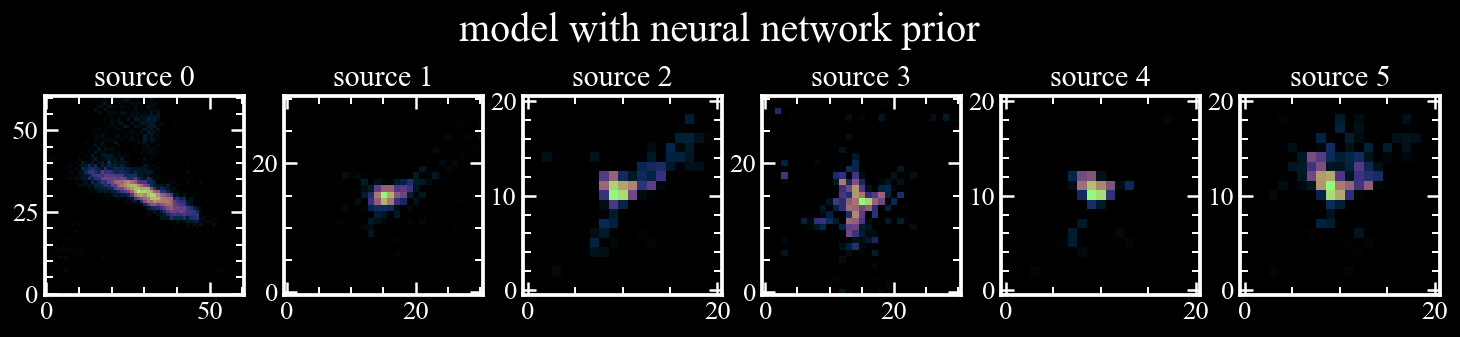

<Figure size 2000x1400 with 0 Axes>

In [135]:
fig, axes = plt.subplots(1, len( scene.sources ), figsize=(15,6),dpi=120)
for i, ax in enumerate(axes):
    y = scene.sources[i].morphology.value
    ax.imshow(y, cmap = cmap, vmin = 0,interpolation=int_method)
    ax.set_title(f"source {i}", fontsize = 18)
    ax.invert_yaxis()
plt.suptitle('model with neural network prior', fontsize=24,y=0.75)
#plt.suptitle('model no prior', fontsize=24,y=0.75)
plt.show()
plt.clf()